In [ ]:
# Cropping image to capture face only
import cv2
import os
from random import random  # Import the random function
import matplotlib.pyplot as plt

def cropImg(imgPath):
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    img = cv2.imread(imgPath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detecting faces in image
    faces = faceCascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5, minSize = (30, 30))

    # Returning the original image if no face is detected
    if len(faces) == 0:
        return img

    # Finding largest face from image (if multiple are detected)
    x, y, w, h = max(faces, key = lambda x : x[2] * x[3])
    croppedImg = img[y:y + h, x:x + w]

    # Plotting about 0.3% random original and cropped images
    if random() < 0.003: # Call the random function
        plt.figure(figsize = (6, 3))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        # Cropped image
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(croppedImg, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image')
        plt.axis('off')

        plt.show()

    return croppedImg

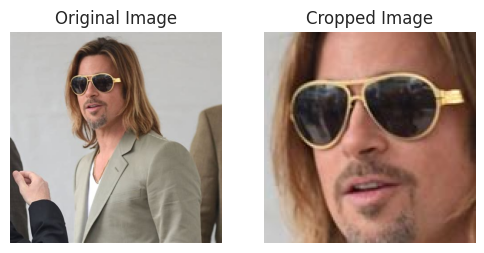

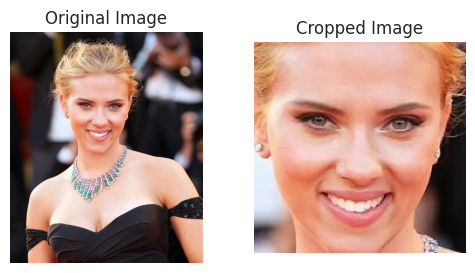

In [ ]:
path = '/content/drive/MyDrive/face_rec/dataset/valid'

croppedPath = '/content/drive/MyDrive/face_rec/Cropped_valid'
os.makedirs(croppedPath, exist_ok = True)

for folder in os.listdir(path):
    folderPath = os.path.join(path, folder)

    # Making folder for each celebrity
    croppedFolderPath = os.path.join(croppedPath, folder)
    os.makedirs(croppedFolderPath, exist_ok = True)

    for img in os.listdir(folderPath):
        imgPath = os.path.join(folderPath, img)
        croppedFace = cropImg(imgPath)

        croppedImgPath = os.path.join(croppedFolderPath, img)
        cv2.imwrite(croppedImgPath, croppedFace)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import (
    Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense,
    MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate, SeparableConv2D, UpSampling2D,
)
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

from PIL import Image, ImageOps  # Pillow library
import random

# Additional imports from the code snippet
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from keras import models, layers
from keras.callbacks import TensorBoard
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical

# Set random seed
np.random.seed(1000)
# Ignore information messages from TensorFlow, but we will receive error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
PARENT_DATA_DIR = '/content/drive/MyDrive/face_rec/Data'
TRAIN_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'valid')
TEST_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'test')

In [ ]:
IMG_SIZE = 64
dataset_classes = []
for i in os.listdir(TRAIN_DATA_DIR):
    dataset_classes.append(i)

number_of_classes = len(dataset_classes)
print(f"""

    Classes: {dataset_classes}
    Number of classes: {number_of_classes}""")



    Classes: ['Leonardo DiCaprio', 'Nicole Kidman', 'Angelina Jolie', 'Tom Cruise']
    Number of classes: 4


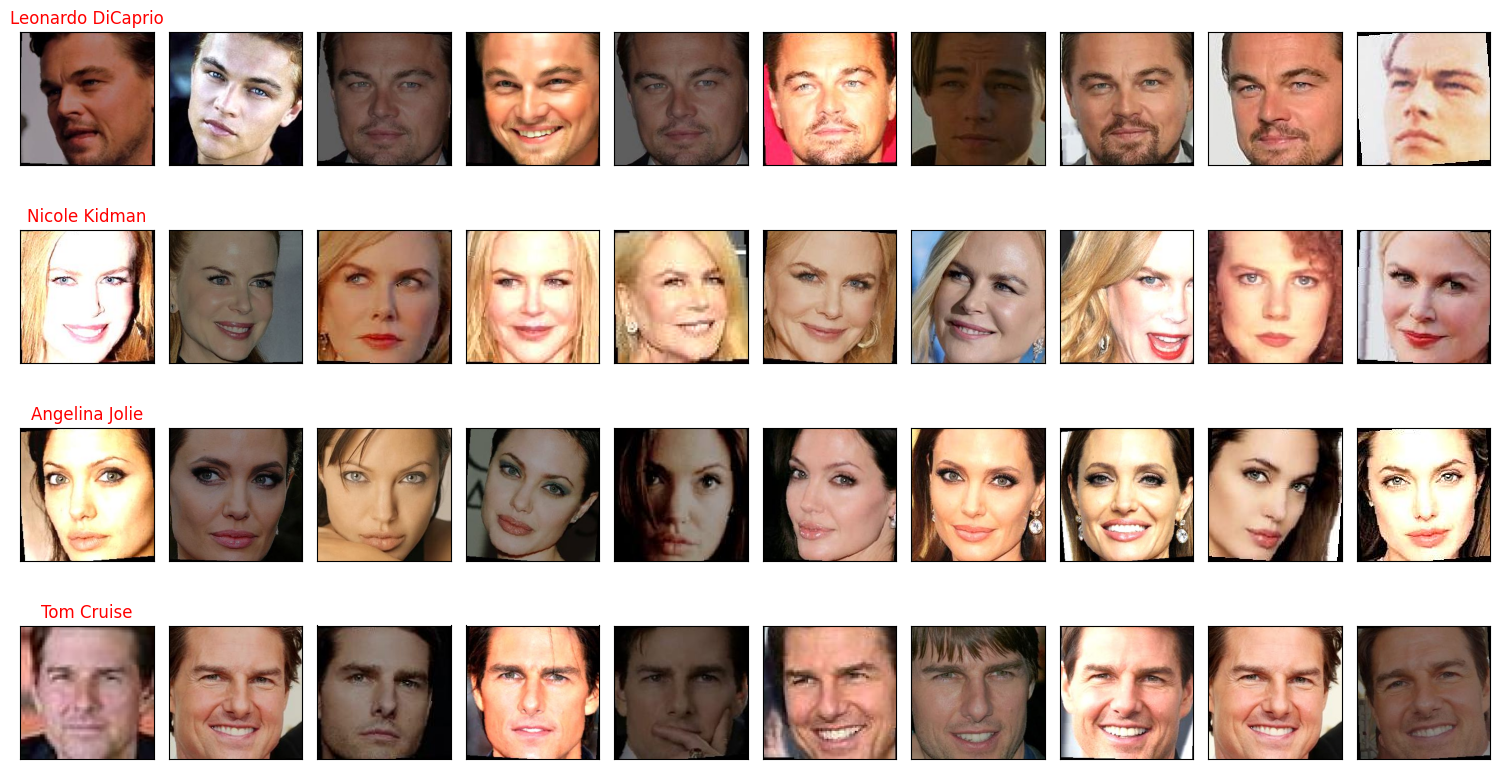

In [ ]:
plt.figure(figsize=(15, 20), facecolor='white')
i = 1
for c in dataset_classes:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    random.shuffle(image_list)
    image_list = image_list[:10]
    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1], :] = img_array

        # Check if 'i' exceeds the maximum number of subplots
        if i > 100:
            break  # Exit the inner loop if 'i' exceeds 100

        plt.subplot(10, 10, i)
        plt.imshow(white_background)
        if i % 10 == 1:
            plt.title(c, color='red')
        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
training_data = []

for c in dataset_classes:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = dataset_classes.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 1000/1000 [00:41<00:00, 23.90it/s]

4000


In [ ]:
validation_data = []

for c in dataset_classes:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = dataset_classes.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            validation_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(validation_data))

100%|██████████| 20/20 [00:09<00:00,  2.19it/s]

80


In [ ]:
test_data = []

for c in dataset_classes:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = dataset_classes.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

40


In [ ]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (4000, 64, 64, 3) Y_train= (4000,)


In [ ]:
X_valid = []
Y_valid = []

for features,label in validation_data:
    X_valid.append(features)
    Y_valid.append(label)

X_valid = np.array(X_valid).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (80, 64, 64, 3) Y_valid= (80,)


In [ ]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

X_test= (40, 64, 64, 3) Y_test= (40,)


### Efficientnet B4

In [ ]:
!pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
import efficientnet.tfkeras as efn

enet = efn.EfficientNetB4(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(number_of_classes, activation='softmax')(x)

e_model_b4 = tf.keras.Model(inputs=enet.input, outputs=y)
e_model_b4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

71892840/71892840 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
efficientnet_b4 = e_model_b4.fit(x=X_train, y=Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=64)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.5838 - loss: 1.3011 - val_accuracy: 0.5625 - val_loss: 1.0841
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.9744 - loss: 0.0829 - val_accuracy: 0.8250 - val_loss: 0.5896
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9900 - loss: 0.0287 - val_accuracy: 0.8875 - val_loss: 0.4246
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.9934 - loss: 0.0207 - val_accuracy: 0.9000 - val_loss: 0.4975
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9958 - loss: 0.0180 - val_accuracy: 0.9250 - val_loss: 0.3908
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.9946 - loss: 0.0183 - val_accuracy: 0.9125 - val_loss: 0.4930
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9895 - loss: 0.0245 - val_accuracy: 0.9250 - val_loss: 0.3752
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9979 - loss: 0.0073 - val_accura

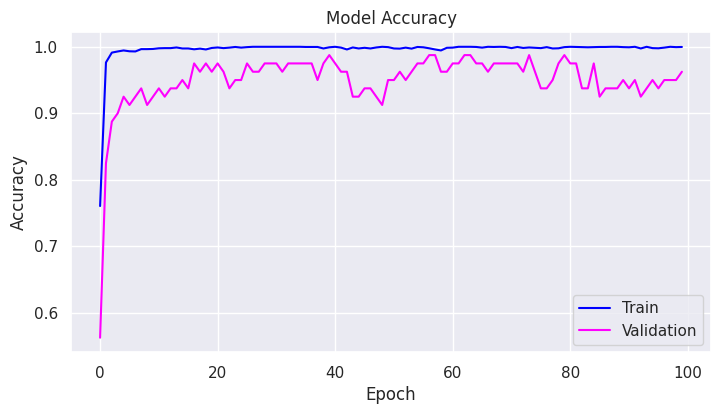

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b4.history['accuracy'],color="blue")
plt.plot(efficientnet_b4.history['val_accuracy'], color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

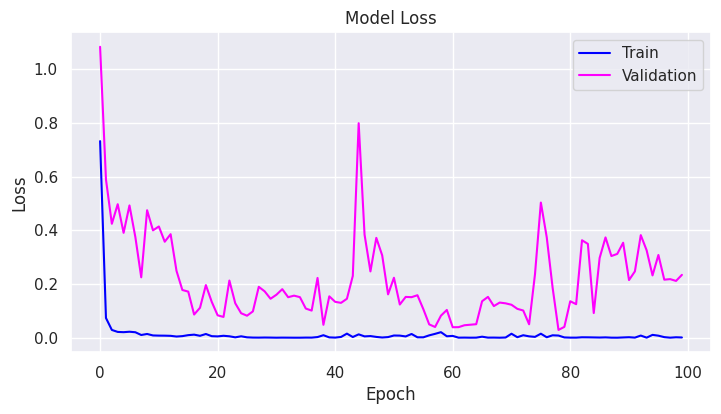

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b4.history['loss'], color="blue")
plt.plot(efficientnet_b4.history['val_loss'], color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = e_model_b4.evaluate(X_valid, Y_valid)
train_loss, train_acc=e_model_b4.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9734 - loss: 0.1701
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 4.1338e-06

Validation Accuracy: 0.9624999761581421

Validation Loss: 0.2342560589313507

Train Accuracy: 1.0

Train Loss: 4.248305685905507e-06


In [ ]:
score = e_model_b4.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  96.25 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(e_model_b4.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step
                   precision    recall  f1-score   support

Leonardo DiCaprio      0.952     1.000     0.976        20
    Nicole Kidman      0.950     0.950     0.950        20
   Angelina Jolie      0.950     0.950     0.950        20
       Tom Cruise      1.000     0.950     0.974        20

         accuracy                          0.963        80
        macro avg      0.963     0.962     0.962        80
     weighted avg      0.963     0.963     0.962        80



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

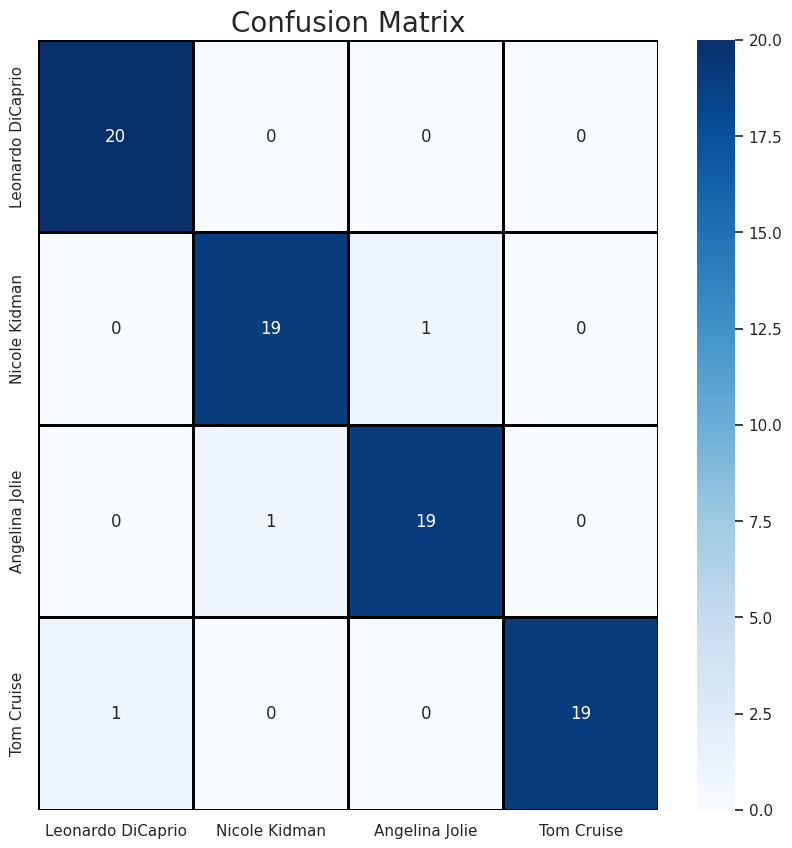

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


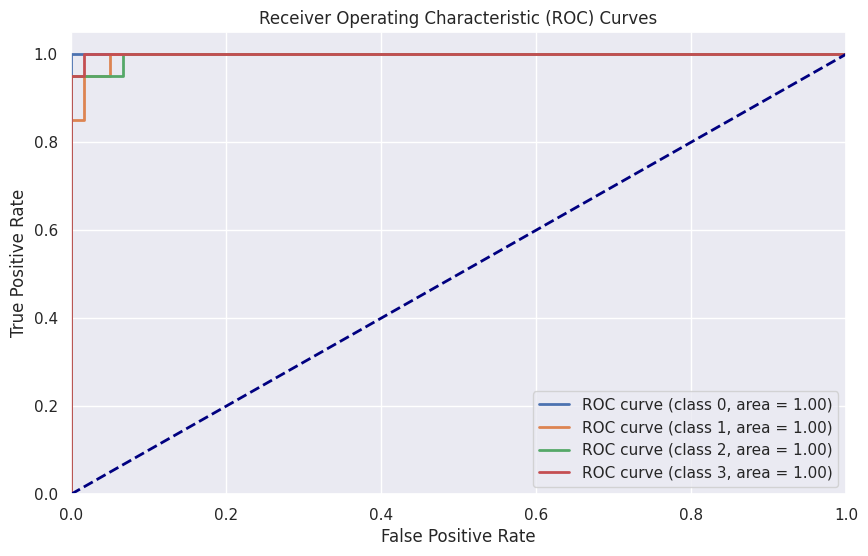

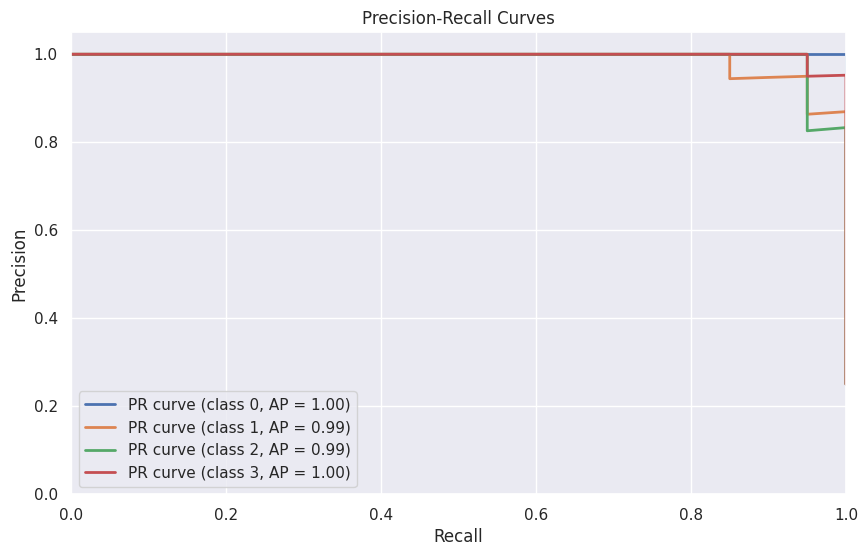

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = e_model_b4.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

In [30]:
# prompt: save model just .h5

e_model_b4.save('my_model.h5')

In [28]:
# Save the model architecture to JSON
model_json = e_model_b4.to_json()
with open("/content/drive/MyDrive/face_rec/model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
# Changed the filename to include .weights before .h5
e_model_b4.save_weights("/content/drive/MyDrive/face_rec/model_weights.weights.h5")
print("Saved model to disk")

Saved model to disk


In [45]:
# prompt: prediction script

import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd
import efficientnet.tfkeras as efn


# Load the model architecture from JSON
with open("/content/drive/MyDrive/face_rec/model_architecture.json", "r") as json_file:
    model_json = json_file.read()

# Create the model from the loaded JSON
model = tf.keras.models.model_from_json(model_json)

# Load the model weights
model.load_weights("/content/drive/MyDrive/face_rec/model_weights.weights.h5")

# Compile the model (necessary before prediction)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

IMG_SIZE = 64
dataset_classes = ['Leonardo DiCaprio','Nicole Kidman','Angelina Jolie','Tom Cruise'] #Replace with your actual classes.

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0
    return img_array

def predict_image(image_path):
    processed_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class = dataset_classes[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    return predicted_class, confidence



In [48]:
# Example usage:
image_path = '/content/drive/MyDrive/face_rec/Data/test/Angelina Jolie/001_fe3347c0.jpg' # Replace with the path to your image
predicted_class, confidence = predict_image(image_path)

print(f"Predicted Class: {predicted_class}")
# print(f"Confidence: {confidence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Class: Angelina Jolie


In [ ]:
# prompt: multiple image

import matplotlib.pyplot as plt
import os
import random

# Assuming dataset_classes is defined as in your original code
dataset_classes = ['Tom Cruise', 'Tom Hanks', 'Denzel Washington', 'Brad Pitt', 'Angelina Jolie', 'Sandra Bullock', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Leonardo DiCaprio', 'Hugh Jackman', 'Kate Winslet', 'Jennifer Lawrence', 'Megan Fox', 'Johnny Depp', 'Will Smith', 'Scarlett Johansson']

# Number of images to display per class
images_per_class = 5

plt.figure(figsize=(15, 10))  # Adjust figure size as needed

for i, class_name in enumerate(dataset_classes):
    class_dir = os.path.join(TEST_DATA_DIR, class_name)  # Assuming TEST_DATA_DIR is defined

    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    image_files = os.listdir(class_dir)
    random.shuffle(image_files)
    image_files = image_files[:images_per_class]

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_dir, image_file)
        try:
            img = plt.imread(image_path)
            plt.subplot(len(dataset_classes), images_per_class, i * images_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:  # Add class label only to the first image of each class
                plt.title(class_name)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

plt.tight_layout()
plt.show()

In [49]:
# prompt: prediction script just model.h5 load model and predict image

import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('/content/my_model.h5')

IMG_SIZE = 64
dataset_classes = ['Leonardo DiCaprio','Nicole Kidman','Angelina Jolie','Tom Cruise'] #Replace with your actual classes.

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0
    return img_array

def predict_image(image_path):
    processed_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class = dataset_classes[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    return predicted_class, confidence

# Example usage:
image_path = '/content/drive/MyDrive/face_rec/Data/test/Leonardo DiCaprio/005_7fe5b764.jpg' # Replace with the path to your image
predicted_class, confidence = predict_image(image_path)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted Class: Leonardo DiCaprio
Confidence: 0.9999998807907104
